# GAN으로 새로운 패션아이템 생성하기
*GAN을 이용하여 새로운 패션 아이템을 만들어봅니다*

이 프로젝트는 최윤제님의 파이토치 튜토리얼 사용 허락을 받아 참고했습니다.

* [yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial) - MIT License

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

EPOCHS 과 BATCH_SIZE 등 학습에 필요한 하이퍼 파라미터 들을 설정해 줍니다.

In [2]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


학습에 필요한 데이터셋을 로딩합니다. 

In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw




Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


생성자는 64차원의 랜덤한 텐서를 입력받아 이에 행렬곱(Linear)과 활성화 함수(ReLU, Tanh) 연산을 실행합니다. 생성자의 결과값은 784차원, 즉 Fashion MNIST 속의 이미지와 같은 차원의 텐서입니다.

In [4]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

판별자는 784차원의 텐서를 입력받습니다. 판별자 역시 입력된 데이터에 행렬곱과 활성화 함수를 실행시키지만, 생성자와 달리 판별자의 결과값은 입력받은 텐서가 진짜인지 구분하는 예측값입니다.

In [5]:
# 판별자 (Discriminator)
# Leaky ReLU : 약간의 음의 기울기도 다음 layer로 전달
# discriminator에서 계산한 기울기가 0이 아닌 약한 음수로 전환되며 생성자 측에 더 강하게 전달
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

생성자와 판별자 학습에 쓰일 오차 함수와 최적화 알고리즘도 정의해 줍니다.

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
# CUDA(GPU) / CPU
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

모델 학습에 필요한 준비는 끝났습니다. 그럼 본격적으로 GAN을 학습시키는 loop을 만들어 보겠습니다. 

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)# [1,1,1...]
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)# [0.0,0...]
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images) # 진짜 이미지를 discriminator의 입력으로 제공
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z) #G의 입력으로 랜덤 텐서 제공, G가 fake image 생성
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)# 가짜 이미지를 discriminator의 입력으로 제공
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 Discriminator의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        #------ Discriminator 학습 ------#
        # 역전파 알고리즘으로 Discriminator의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()# Discriminator 학습
        
        # 생성자가 판별자를 속였는지에 대한 오차(Generator의 loss)를 계산
        fake_images = G(z)
        outputs = D(fake_images) #한번 학습한 D가 fake image를 
        g_loss = criterion(outputs, real_labels)

         #------ Generator 학습 ------#
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.0882, g_loss: 3.8892, D(x): 0.98, D(G(z)): 0.06
Epoch [1/500], d_loss: 0.1201, g_loss: 4.6757, D(x): 0.96, D(G(z)): 0.03
Epoch [2/500], d_loss: 0.0314, g_loss: 8.3980, D(x): 0.98, D(G(z)): 0.00
Epoch [3/500], d_loss: 0.0294, g_loss: 7.9051, D(x): 0.98, D(G(z)): 0.01
Epoch [4/500], d_loss: 0.1974, g_loss: 3.8088, D(x): 0.95, D(G(z)): 0.08
Epoch [5/500], d_loss: 0.0885, g_loss: 4.8908, D(x): 0.97, D(G(z)): 0.02
Epoch [6/500], d_loss: 0.0711, g_loss: 4.6400, D(x): 0.98, D(G(z)): 0.05
Epoch [7/500], d_loss: 0.3527, g_loss: 4.5870, D(x): 0.92, D(G(z)): 0.08
Epoch [8/500], d_loss: 0.2239, g_loss: 5.8944, D(x): 0.92, D(G(z)): 0.01
Epoch [9/500], d_loss: 0.3074, g_loss: 5.9306, D(x): 0.91, D(G(z)): 0.04
Epoch [10/500], d_loss: 0.2687, g_loss: 5.2147, D(x): 0.95, D(G(z)): 0.12
Epoch [11/500], d_loss: 0.2224, g_loss: 3.8949, D(x): 0.93, D(G(z)): 0.05
Epoch [12/500], d_loss: 0.2381, g_loss: 3.6749, D(x): 0.95, D(G(z)): 0.13
Epoch [13/500], d_loss: 0.2247, g_loss: 4.5067, 

학습이 끝난 생성자의 결과물을 한번 확인해 보겠습니다.

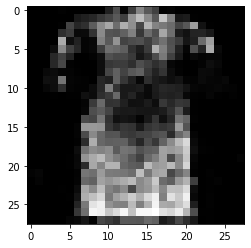

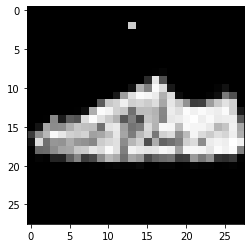

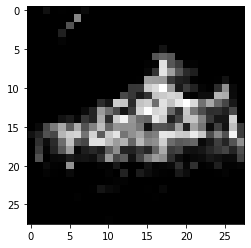

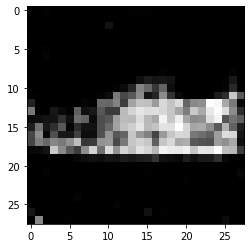

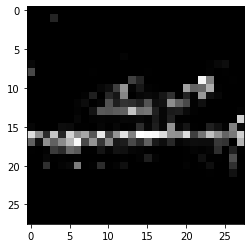

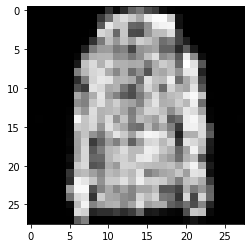

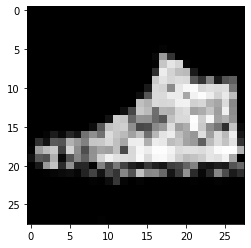

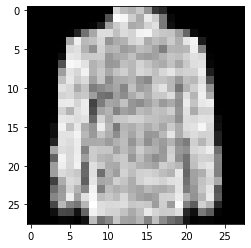

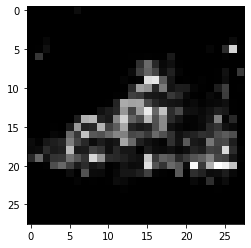

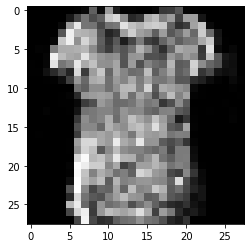

In [8]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()